# Introduction

The experimentation pipeline will be the following: We'll take a baseline configuration detailed below, and we're going to perform experiments in diferent aspects of the whole pipeline. As we make those experiments, we'll update the baseline keeping the balance with the best results from the previous experiments and hyperparameters that don't compromise the experimentation speed. We're going to use the following baseline for experimentation:
- Descriptor: SIFT, as the common algorithm for feature extraction in classic literature
- Number of features: 500
- Size of codebook: 512 (For initial fast clustering experimentation)
- Normalization: L2 in histograms
- Spatial Pyramids: No pyramid (no level)
- Dimensionality reuction: None (first we try with the whole data)
- Classifier: Logistic Regression (fast and easy hyperparameters for base experimentation)


With this pipeline, we're going to try:
- Number of local features in descriptors
- SIFT / AKAZE / ORB / Dense SIFT
- Spatial pyramids vs no spatial pyramids
- Try normalization and scale
- Size of codebook
- Try dimensionality reduction
- Classifiers: Logistic Regression vs SVM vs KNN
- Fisher Vectors





# Experiments

In [4]:
from main import *
from bovw import *

import os
import random
import numpy as np
import pandas as pd


%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [6]:
data_train = Dataset(ImageFolder="../data/places_reduced/train")
data_test = Dataset(ImageFolder="../data/places_reduced/val")

len(data_train), len(data_test)

(8700, 2200)

In [7]:
random.shuffle(data_train)
random.shuffle(data_test)

0


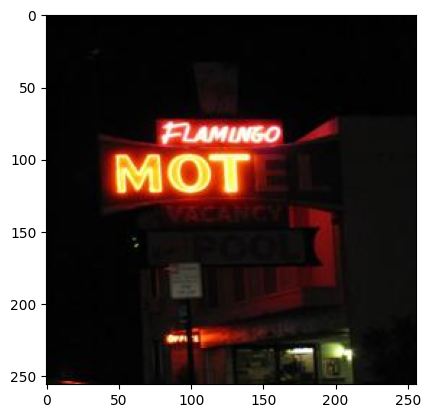

In [8]:
sample_idx = 70
print(data_train[sample_idx][1])
plt.imshow(np.array(data_train[sample_idx][0]))
plt.show()

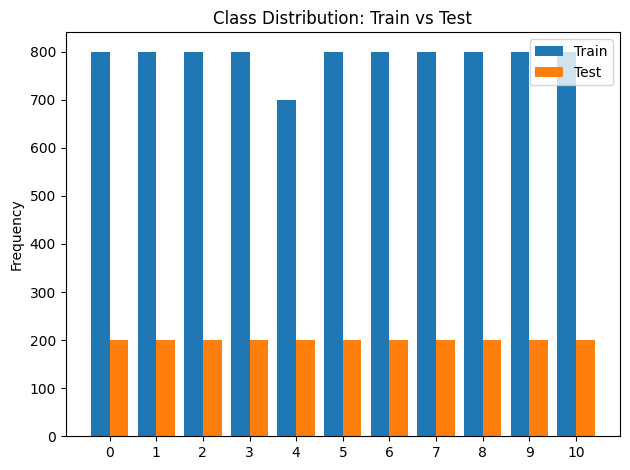

In [9]:
train_class_counter = Counter(entry[1] for entry in data_train)
test_class_counter = Counter(entry[1] for entry in data_test)

classes = sorted(train_class_counter.keys())  # or union with test if needed
train_counts = [train_class_counter[c] for c in classes]
test_counts = [test_class_counter[c] for c in classes]

width = 0.4
x = range(len(classes))

plt.bar([xi - width/2 for xi in x], train_counts, width=width, label="Train")
plt.bar([xi + width/2 for xi in x], test_counts, width=width, label="Test")

plt.xticks(x, classes)
plt.ylabel("Frequency")
plt.title("Class Distribution: Train vs Test")
plt.legend()
plt.tight_layout()
plt.show()

All classes have 800 training images except for class 4 ("industrial and construction"), which has 700.

All classes have 200 test samples.

In [10]:
#Execution example:


"""
bovw_params = {
    "detector_type": "DSIFT",
    "codebook_size": 100, 
    "detector_kwargs": {"nfeatures": 100},
    "dense_kwargs": {"step": 16, "size": 16}
}

classifier_cls = SVC
classifier_params = {
    "kernel": 'rbf', 
}

scores = cross_validate_bovw(
    data_train,
    bovw_kwargs=bovw_params,
    classifier_cls=classifier_cls,
    classifier_kwargs=classifier_params
)

scores.test.accuracy.mean
"""

'\nbovw_params = {\n    "detector_type": "DSIFT",\n    "codebook_size": 100, \n    "detector_kwargs": {"nfeatures": 100},\n    "dense_kwargs": {"step": 16, "size": 16}\n}\n\nclassifier_cls = SVC\nclassifier_params = {\n    "kernel": \'rbf\', \n}\n\nscores = cross_validate_bovw(\n    data_train,\n    bovw_kwargs=bovw_params,\n    classifier_cls=classifier_cls,\n    classifier_kwargs=classifier_params\n)\n\nscores.test.accuracy.mean\n'

## A) Descriptors (SIFT vs AKAZE vs ORB) and number of features

Comparision of descriptors (SIFT vs AKAZE vs ORB) while trying different hyperparameters on the descriptors (including the number of features)

In [11]:
enable_cache()

In [ ]:
# SIFT
print("TESTING SIFT DESCRIPTOR")

sift_nfeatures = [250, 500, 1000, 2000]
sift_results = {}

for nfeatures in sift_nfeatures:
    print(f"\nSIFT with nfeatures={nfeatures}")
    
    bovw_params = {
        "detector_type": "SIFT",
        "codebook_size": 512,
        "descriptor_normalization": "L2",
        "detector_kwargs": {"nfeatures": nfeatures},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    sift_results[nfeatures] = scores
    
    print(f"[SIFT nfeatures={nfeatures}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")


print("\nSIFT SUMMARY")
for nfeatures in sift_nfeatures:
    print(f"nfeatures={nfeatures:4d} -> Accuracy Train: {sift_results[nfeatures].train.accuracy.mean:.4f} ± {sift_results[nfeatures].train.accuracy.std:.4f}")
    print(f"nfeatures={nfeatures:4d} -> Accuracy Test: {sift_results[nfeatures].test.accuracy.mean:.4f} ± {sift_results[nfeatures].test.accuracy.std:.4f}")
    print("")

TESTING SIFT DESCRIPTOR
SIFT with nfeatures=100


Phase [Setup]: Extracting the descriptors:   6%|▌         | 480/8700 [00:07<02:14, 60.93it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5088/8700 [01:13<00:56, 63.61it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:01<00:00, 36.37s/it]



[SIFT nfeatures=100] Results:
  Train Accuracy:  0.4066 ± 0.0071
  Test Accuracy:   0.2428 ± 0.0098
  Test Precision:  0.2332 ± 0.0099
  Test Recall:     0.2428 ± 0.0098
  Test F1-Score:   0.2355 ± 0.0094
SIFT with nfeatures=250


Phase [Setup]: Extracting the descriptors:   5%|▌         | 475/8700 [00:07<02:01, 67.86it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5087/8700 [01:36<01:08, 52.44it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:43<00:00, 44.71s/it]



[SIFT nfeatures=250] Results:
  Train Accuracy:  0.4316 ± 0.0058
  Test Accuracy:   0.2828 ± 0.0084
  Test Precision:  0.2722 ± 0.0084
  Test Recall:     0.2828 ± 0.0084
  Test F1-Score:   0.2744 ± 0.0083
SIFT with nfeatures=500


Phase [Setup]: Extracting the descriptors:   5%|▌         | 476/8700 [00:08<02:28, 55.54it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5086/8700 [01:36<01:13, 48.97it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:18<00:00, 51.60s/it]



[SIFT nfeatures=500] Results:
  Train Accuracy:  0.4434 ± 0.0050
  Test Accuracy:   0.3121 ± 0.0028
  Test Precision:  0.3033 ± 0.0037
  Test Recall:     0.3121 ± 0.0028
  Test F1-Score:   0.3043 ± 0.0041
SIFT with nfeatures=1000


Phase [Setup]: Extracting the descriptors:   5%|▌         | 477/8700 [00:10<02:55, 46.73it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5086/8700 [01:44<01:04, 55.90it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:41<00:00, 56.36s/it]



[SIFT nfeatures=1000] Results:
  Train Accuracy:  0.4508 ± 0.0022
  Test Accuracy:   0.3275 ± 0.0091
  Test Precision:  0.3180 ± 0.0114
  Test Recall:     0.3275 ± 0.0091
  Test F1-Score:   0.3195 ± 0.0104

SIFT SUMMARY
nfeatures= 100 -> Accuracy Train: 0.4066 ± 0.0071
nfeatures= 100 -> Accuracy Test: 0.2428 ± 0.0098

nfeatures= 250 -> Accuracy Train: 0.4316 ± 0.0058
nfeatures= 250 -> Accuracy Test: 0.2828 ± 0.0084

nfeatures= 500 -> Accuracy Train: 0.4434 ± 0.0050
nfeatures= 500 -> Accuracy Test: 0.3121 ± 0.0028

nfeatures=1000 -> Accuracy Train: 0.4508 ± 0.0022
nfeatures=1000 -> Accuracy Test: 0.3275 ± 0.0091



SIFT SUMMARY
- nfeatures= 100 -> Accuracy Train: 0.4066 ± 0.0071
- nfeatures= 100 -> Accuracy Test: 0.2428 ± 0.0098

- nfeatures= 250 -> Accuracy Train: 0.4316 ± 0.0058
- nfeatures= 250 -> Accuracy Test: 0.2828 ± 0.0084

- nfeatures= 500 -> Accuracy Train: 0.4434 ± 0.0050
- nfeatures= 500 -> Accuracy Test: 0.3121 ± 0.0028

- nfeatures=1000 -> Accuracy Train: 0.4508 ± 0.0022
- nfeatures=1000 -> Accuracy Test: 0.3275 ± 0.0091


In [ ]:
# AKAZE
print("TESTING AKAZE DESCRIPTOR")

akaze_threshold = [0.0004, 0.0008, 0.0012]
akaze_results = {}

for thr in akaze_threshold:
    print(f"\nAKAZE with threshold={thr}")
    
    bovw_params = {
        "detector_type": "AKAZE",
        "codebook_size": 512,
        "descriptor_normalization": "L2",
        "detector_kwargs": {"threshold": thr},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    akaze_results[thr] = scores
    
    print(f"[AKAZE threshold={thr}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")

print("\nAKAZE SUMMARY")
for thr in akaze_threshold:
    print(f"thr={thr} -> Accuracy Train: {akaze_results[thr].train.accuracy.mean:.4f} ± {akaze_results[thr].train.accuracy.std:.4f}")
    print(f"thr={thr} -> Accuracy Test: {akaze_results[thr].test.accuracy.mean:.4f} ± {akaze_results[thr].test.accuracy.std:.4f}")
    print("")

TESTING AKAZE DESCRIPTOR

AKAZE with threshold=0.0004


Phase [Setup]: Extracting the descriptors:   0%|          | 0/8700 [00:00<?, ?it/s]

Phase [Setup]: Extracting the descriptors:   6%|▌         | 485/8700 [00:05<01:33, 87.46it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 818/8700 [00:10<01:24, 93.03it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  19%|█▊        | 1629/8700 [00:21<01:29, 79.27it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  25%|██▍       | 2168/8700 [00:30<01:35, 68.42it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001057.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5084/8700 [01:11<00:48, 74.49it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  76%|███████▋  | 6636/8700 [01:32<00:25, 82.08it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  95%|█████████▌| 8275/8700 [01:54<00:05, 77.85it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00003623.jpg of class 7.


100%|██████████| 5/5 [04:04<00:00, 48.83s/it]


[AKAZE threshold=0.0004] Results:
  Train Accuracy:  0.3624 ± 0.0027
  Test Accuracy:   0.2098 ± 0.0091
  Test Precision:  0.2042 ± 0.0103
  Test Recall:     0.2098 ± 0.0091
  Test F1-Score:   0.2047 ± 0.0095

AKAZE with threshold=0.0008


Phase [Setup]: Extracting the descriptors:   2%|▏         | 151/8700 [00:01<01:49, 78.09it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\cliff_00001932.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   6%|▌         | 481/8700 [00:06<01:42, 80.35it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 816/8700 [00:10<01:40, 78.27it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  19%|█▊        | 1626/8700 [00:20<01:36, 73.53it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  23%|██▎       | 1968/8700 [00:24<01:31, 73.50it/s]

Could not compute descriptors for image ../data/places_reduced/train\forest_field_jungle\pasture_00002164.jpg of class 1.


Phase [Setup]: Extracting the descriptors:  25%|██▍       | 2168/8700 [00:27<01:28, 73.52it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001057.jpg of class 5.
Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\mountain_00002707.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5088/8700 [01:03<00:43, 83.69it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  63%|██████▎   | 5518/8700 [01:08<00:38, 82.92it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00000226.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  76%|███████▋  | 6634/8700 [01:22<00:24, 84.14it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  77%|███████▋  | 6724/8700 [01:23<00:24, 81.55it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\cliff_00001485.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  95%|█████████▌| 8275/8700 [01:43<00:06, 64.65it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00003623.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  97%|█████████▋| 8421/8700 [01:45<00:03, 82.09it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00004426.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  99%|█████████▉| 8633/8700 [01:48<00:00, 83.18it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00000137.jpg of class 5.


100%|██████████| 5/5 [03:12<00:00, 38.45s/it]


[AKAZE threshold=0.0008] Results:
  Train Accuracy:  0.3563 ± 0.0063
  Test Accuracy:   0.2023 ± 0.0088
  Test Precision:  0.1969 ± 0.0110
  Test Recall:     0.2023 ± 0.0088
  Test F1-Score:   0.1970 ± 0.0098

AKAZE with threshold=0.0012


Phase [Setup]: Extracting the descriptors:   2%|▏         | 155/8700 [00:01<01:31, 93.58it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\cliff_00001932.jpg of class 5.


Phase [Setup]: Extracting the descriptors:   5%|▍         | 431/8700 [00:04<01:46, 77.42it/s] 

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00003791.jpg of class 7.


Phase [Setup]: Extracting the descriptors:   5%|▌         | 477/8700 [00:05<01:36, 85.04it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 823/8700 [00:08<01:21, 97.09it/s] 

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  19%|█▊        | 1623/8700 [00:17<01:07, 104.63it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports_fields\promenade_00000058.jpg of class 8.
Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\volcano_00004486.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  23%|██▎       | 1974/8700 [00:20<01:12, 92.31it/s] 

Could not compute descriptors for image ../data/places_reduced/train\forest_field_jungle\pasture_00002164.jpg of class 1.


Phase [Setup]: Extracting the descriptors:  25%|██▍       | 2172/8700 [00:22<01:04, 100.60it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001057.jpg of class 5.
Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\mountain_00002707.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  32%|███▏      | 2799/8700 [00:30<01:14, 79.46it/s] 

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00003849.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  50%|████▉     | 4335/8700 [00:48<00:46, 93.54it/s] 

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\hot_spring_00003968.jpg of class 9.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5052/8700 [00:56<00:41, 88.35it/s] 

Could not compute descriptors for image ../data/places_reduced/train\home or hotel\bathroom_00000599.jpg of class 2.


Phase [Setup]: Extracting the descriptors:  59%|█████▊    | 5091/8700 [00:56<00:39, 92.49it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  63%|██████▎   | 5471/8700 [01:00<00:35, 91.69it/s] 

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\volcano_00000431.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  63%|██████▎   | 5511/8700 [01:01<00:34, 91.94it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00000226.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  76%|███████▋  | 6637/8700 [01:13<00:21, 94.55it/s] 

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\canyon_00003418.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  77%|███████▋  | 6719/8700 [01:14<00:22, 87.78it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\cliff_00001485.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  89%|████████▊ | 7703/8700 [01:24<00:10, 92.83it/s] 

Could not compute descriptors for image ../data/places_reduced/train\home or hotel\basement_00001438.jpg of class 2.


Phase [Setup]: Extracting the descriptors:  92%|█████████▏| 8047/8700 [01:28<00:07, 92.88it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\volcano_00002718.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  95%|█████████▌| 8283/8700 [01:31<00:04, 93.35it/s] 

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00003623.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  97%|█████████▋| 8422/8700 [01:32<00:03, 90.64it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00004426.jpg of class 5.


Phase [Setup]: Extracting the descriptors:  99%|█████████▉| 8639/8700 [01:35<00:00, 92.95it/s] 

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00000137.jpg of class 5.


100%|██████████| 5/5 [03:37<00:00, 43.56s/it]

[AKAZE threshold=0.0012] Results:
  Train Accuracy:  0.3528 ± 0.0059
  Test Accuracy:   0.1911 ± 0.0109
  Test Precision:  0.1832 ± 0.0098
  Test Recall:     0.1911 ± 0.0109
  Test F1-Score:   0.1844 ± 0.0102

AKAZE SUMMARY


ValueError: Unknown format code 'd' for object of type 'float'

[AKAZE threshold=0.0004] Results:
-  Train Accuracy:  0.3624 ± 0.0027
-  Test Accuracy:   0.2098 ± 0.0091

[AKAZE threshold=0.0008] Results:
-  Train Accuracy:  0.3563 ± 0.0063
-  Test Accuracy:   0.2023 ± 0.0088

[AKAZE threshold=0.0012] Results:
-  Train Accuracy:  0.3528 ± 0.0059
-  Test Accuracy:   0.1911 ± 0.0109

In [18]:
# ORB
print("TESTING ORB DESCRIPTOR")

orb_nfeatures = [250, 500, 1000, 2000]
orb_results = {}

for nfeatures in orb_nfeatures:
    print(f"\nORB with nfeatures={nfeatures}")
    
    bovw_params = {
        "detector_type": "ORB",
        "codebook_size": 512,
        "descriptor_normalization": "L2",
        "detector_kwargs": {"nfeatures": nfeatures},
    }
    
    classifier_cls = LogisticRegression
    classifier_params = {
        "max_iter": 1000,
        "class_weight": "balanced",
    }
    
    scores = cross_validate_bovw(
        data_train,
        bovw_kwargs=bovw_params,
        classifier_cls=classifier_cls,
        classifier_kwargs=classifier_params,
        n_splits=5,
        verbose=False,
    )
    
    orb_results[nfeatures] = scores
    
    print(f"[ORB nfeatures={nfeatures}] Results:")
    print(f"  Train Accuracy:  {scores.train.accuracy.mean:.4f} ± {scores.train.accuracy.std:.4f}")
    print(f"  Test Accuracy:   {scores.test.accuracy.mean:.4f} ± {scores.test.accuracy.std:.4f}")
    print(f"  Test Precision:  {scores.test.precision.mean:.4f} ± {scores.test.precision.std:.4f}")
    print(f"  Test Recall:     {scores.test.recall.mean:.4f} ± {scores.test.recall.std:.4f}")
    print(f"  Test F1-Score:   {scores.test.f1.mean:.4f} ± {scores.test.f1.std:.4f}")

print("\nORB SUMMARY")
for nfeatures in orb_nfeatures:
    print(f"nfeatures={nfeatures:4d} -> Accuracy Train: {orb_results[nfeatures].train.accuracy.mean:.4f} ± {orb_results[nfeatures].train.accuracy.std:.4f}")
    print(f"nfeatures={nfeatures:4d} -> Accuracy Test: {orb_results[nfeatures].test.accuracy.mean:.4f} ± {orb_results[nfeatures].test.accuracy.std:.4f}")
    print("")

TESTING ORB DESCRIPTOR

ORB with nfeatures=250


Phase [Setup]: Extracting the descriptors:   5%|▌         | 476/8700 [00:05<01:42, 80.46it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 818/8700 [00:10<01:44, 75.67it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  58%|█████▊    | 5089/8700 [01:01<00:43, 82.61it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:30<00:00, 42.08s/it]


[ORB nfeatures=250] Results:
  Train Accuracy:  0.3360 ± 0.0046
  Test Accuracy:   0.1659 ± 0.0090
  Test Precision:  0.1625 ± 0.0086
  Test Recall:     0.1659 ± 0.0090
  Test F1-Score:   0.1627 ± 0.0089

ORB with nfeatures=500


Phase [Setup]: Extracting the descriptors:   6%|▌         | 495/8700 [00:02<00:46, 178.17it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 824/8700 [00:04<00:46, 169.07it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  59%|█████▊    | 5108/8700 [00:30<00:21, 168.54it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [03:52<00:00, 46.51s/it]


[ORB nfeatures=500] Results:
  Train Accuracy:  0.3347 ± 0.0042
  Test Accuracy:   0.1842 ± 0.0064
  Test Precision:  0.1786 ± 0.0053
  Test Recall:     0.1842 ± 0.0064
  Test F1-Score:   0.1793 ± 0.0056

ORB with nfeatures=1000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 498/8700 [00:03<00:55, 149.04it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 823/8700 [00:06<00:58, 134.44it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  59%|█████▊    | 5101/8700 [00:36<00:25, 142.59it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [04:47<00:00, 57.42s/it]


[ORB nfeatures=1000] Results:
  Train Accuracy:  0.3375 ± 0.0038
  Test Accuracy:   0.1972 ± 0.0108
  Test Precision:  0.1934 ± 0.0076
  Test Recall:     0.1972 ± 0.0108
  Test F1-Score:   0.1929 ± 0.0086

ORB with nfeatures=2000


Phase [Setup]: Extracting the descriptors:   6%|▌         | 492/8700 [00:04<01:07, 120.88it/s]

Could not compute descriptors for image ../data/places_reduced/train\water_ice_snow\iceberg_00000023.jpg of class 9.


Phase [Setup]: Extracting the descriptors:   9%|▉         | 815/8700 [00:07<01:17, 101.19it/s]

Could not compute descriptors for image ../data/places_reduced/train\sports and leisure\sauna_00001030.jpg of class 7.


Phase [Setup]: Extracting the descriptors:  59%|█████▊    | 5093/8700 [00:45<00:31, 115.72it/s]

Could not compute descriptors for image ../data/places_reduced/train\mountains_hills_desert_sky\sky_00001410.jpg of class 5.


100%|██████████| 5/5 [06:01<00:00, 72.21s/it]


[ORB nfeatures=2000] Results:
  Train Accuracy:  0.3368 ± 0.0040
  Test Accuracy:   0.2070 ± 0.0104
  Test Precision:  0.2035 ± 0.0093
  Test Recall:     0.2070 ± 0.0104
  Test F1-Score:   0.2016 ± 0.0095

ORB SUMMARY
nfeatures= 250 -> Accuracy Train: 0.3360 ± 0.0046
nfeatures= 250 -> Accuracy Test: 0.1659 ± 0.0090

nfeatures= 500 -> Accuracy Train: 0.3347 ± 0.0042
nfeatures= 500 -> Accuracy Test: 0.1842 ± 0.0064

nfeatures=1000 -> Accuracy Train: 0.3375 ± 0.0038
nfeatures=1000 -> Accuracy Test: 0.1972 ± 0.0108

nfeatures=2000 -> Accuracy Train: 0.3368 ± 0.0040
nfeatures=2000 -> Accuracy Test: 0.2070 ± 0.0104



ORB SUMMARY
- nfeatures= 250 -> Accuracy Train: 0.3360 ± 0.0046
- nfeatures= 250 -> Accuracy Test: 0.1659 ± 0.0090

- nfeatures= 500 -> Accuracy Train: 0.3347 ± 0.0042
- nfeatures= 500 -> Accuracy Test: 0.1842 ± 0.0064

- nfeatures=1000 -> Accuracy Train: 0.3375 ± 0.0038
- nfeatures=1000 -> Accuracy Test: 0.1972 ± 0.0108

- nfeatures=2000 -> Accuracy Train: 0.3368 ± 0.0040
- nfeatures=2000 -> Accuracy Test: 0.2070 ± 0.0104

## Comparison and Best Configuration

Comparing all three descriptors across different feature counts to select the best for further experimentation.

In [ ]:
# Comparison of all descriptors
print("SECTION A: FINAL COMPARISON - DESCRIPTORS AND NUMBER OF FEATURES")

# Prepare comparison data
comparison_data = []

for nfeatures in sift_nfeatures:
    comparison_data.append({
        "Descriptor": "SIFT",
        "nfeatures": nfeatures,
        "Train Acc": sift_results[nfeatures].train.accuracy.mean,
        "Test Acc": sift_results[nfeatures].test.accuracy.mean,
        "Test Acc Std": sift_results[nfeatures].test.accuracy.std,
        "Test Prec": sift_results[nfeatures].test.precision.mean,
        "Test Rec": sift_results[nfeatures].test.recall.mean,
        "Test F1": sift_results[nfeatures].test.f1.mean,
    })

for nfeatures in akaze_nfeatures:
    comparison_data.append({
        "Descriptor": "AKAZE",
        "nfeatures": nfeatures,
        "Train Acc": akaze_results[nfeatures].train.accuracy.mean,
        "Test Acc": akaze_results[nfeatures].test.accuracy.mean,
        "Test Acc Std": akaze_results[nfeatures].test.accuracy.std,
        "Test Prec": akaze_results[nfeatures].test.precision.mean,
        "Test Rec": akaze_results[nfeatures].test.recall.mean,
        "Test F1": akaze_results[nfeatures].test.f1.mean,
    })

for nfeatures in orb_nfeatures:
    comparison_data.append({
        "Descriptor": "ORB",
        "nfeatures": nfeatures,
        "Train Acc": orb_results[nfeatures].train.accuracy.mean,
        "Test Acc": orb_results[nfeatures].test.accuracy.mean,
        "Test Acc Std": orb_results[nfeatures].test.accuracy.std,
        "Test Prec": orb_results[nfeatures].test.precision.mean,
        "Test Rec": orb_results[nfeatures].test.recall.mean,
        "Test F1": orb_results[nfeatures].test.f1.mean,
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best configuration
best_idx = comparison_df["Test Acc"].idxmax()
best_config = comparison_df.loc[best_idx]

print("\n" + "=" * 80)
print("BEST CONFIGURATION FOR SECTION A")
print("=" * 80)
print(f"Descriptor: {best_config['Descriptor']}")
print(f"Number of Features: {best_config['nfeatures']}")
print(f"Test Accuracy: {best_config['Test Acc']:.4f} ± {best_config['Test Acc Std']:.4f}")
print(f"Test Precision: {best_config['Test Prec']:.4f}")
print(f"Test Recall: {best_config['Test Rec']:.4f}")
print(f"Test F1-Score: {best_config['Test F1']:.4f}")

# Recommendation for next section
best_descriptor = best_config['Descriptor']
best_nfeatures = int(best_config['nfeatures'])
print(f"\nRecommendation for next sections: Use {best_descriptor} with nfeatures={best_nfeatures}")

## B) Density vs Non Density (SIFT vs Dense SIFT)

ATENCIÓN: AQUÍ ASUMO QUE SIFT SERÁ EL QUE FUNCIONARÁ MEJOR, CANVIAR SI NO ES EL CASO

Since SIFT was the best descriptor, we compare it with Dense SIFT

In [ ]:
disable_cache()

## C) Size of codebook

Try for different codebook sizes (k) 

In [ ]:
enable_cache()

## D) Spatial Pyramids

Comaprision between using and not using spatial pyramids

## E) Classifiers and Normalization

Since the way the data is normalized and preprocessed can depend on the classifier, we're going to try this along the different classifiers and it's hyperparameter search for Logistic Regression, SVM, KNN

## F) Dimensionality Reduction

We're going to try PCA, SVD, LDA, t-SNE

## G) Fisher Vectors

Finally, we're going to do a fisher vector approach